In [1]:
from google.colab import drive
drive.mount("/content/driveG")

Mounted at /content/driveG


In [2]:
import torch
import torchvision

from torch import nn
from torchvision import transforms
from driveG.MyDrive.GP1.Graduation_Project_PCOS.going_modular import data_setup, engine

In [3]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Setup path to PCOS data directory
from pathlib import Path

data_path = Path("/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/")
image_path = data_path / "newER_data"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"{image_path} directory not found")

/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data directory exists.


In [6]:
# Setup Directories
train_dir = image_path / "train"
test_dir = image_path / "validation"

In [14]:
# Create transforms pipeline manually (older method)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224
    transforms.ToTensor(), # Turn pixel values to between 0 & 1
    #transforms.Grayscale() ##### change number of color channels from 3 to 1 (I added this)
])

In [15]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, 
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names                                

(<torch.utils.data.dataloader.DataLoader at 0x7fcd78ce6470>,
 ['infected', 'notinfected'])

In [16]:
len(train_dataloader), len(test_dataloader)

(19, 8)

In [17]:
# Getting a single training batch
images, labels = next(iter(train_dataloader))

In [18]:
# Getting a single image from a batch
rand_number = 4 # must be between 0 and 31 b/c thats the range of batch (32 images in each batch)
rand_img, label = images[rand_number], class_names[labels[rand_number].item()]
rand_img, label

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'infected')

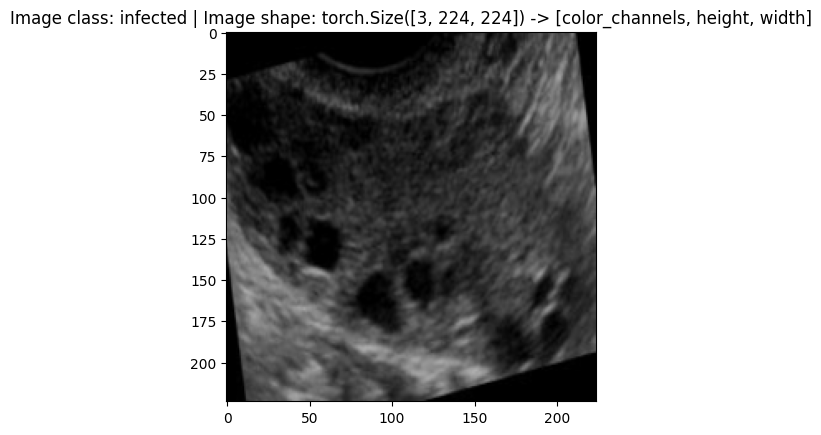

In [19]:
import matplotlib.pyplot as plt

npimg = rand_img.numpy()
# npimg = npimg / 255 # This line was causing the image to appear black
transpose = npimg.transpose((1,2,0)) # Unlike Pytorch, Matplotlib needs to have color_channels last thats why we transpose dimensions
plt.imshow(transpose)
plt.title(f"Image class: {label} | Image shape: {rand_img.shape} -> [color_channels, height, width]")
plt.show()

# Building the Model from scratch:

In [20]:
# Create a convolutional neural network 
class IustNet(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int): # Instructor
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, # There's a trick to calculating this
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.block_2(x)
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        #print(x.shape)
        return x

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = IustNet(input_shape=3, hidden_units=45, output_shape=1).to(device)
model_0

IustNet(
  (block_1): Sequential(
    (0): Conv2d(3, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=141120, out_features=1, bias=True)
  )
)

In [22]:
# Print a summary using torchinfo 
summary(model=model_0,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
IustNet (IustNet)                        [32, 3, 224, 224]    [32, 1]              --                   True
├─Sequential (block_1)                   [32, 3, 224, 224]    [32, 45, 112, 112]   --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 45, 224, 224]   1,260                True
│    └─ReLU (1)                          [32, 45, 224, 224]   [32, 45, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 45, 224, 224]   [32, 45, 224, 224]   18,270               True
│    └─ReLU (3)                          [32, 45, 224, 224]   [32, 45, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 45, 224, 224]   [32, 45, 112, 112]   --                   --
├─Sequential (block_2)                   [32, 45, 112, 112]   [32, 45, 56, 56]     --                   True
│    └─Conv2d (0)   

In [23]:
# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) ##### smaller lr this time

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3926 | train_acc: 0.8487 | test_loss: 0.7582 | test_acc: 0.6858
Epoch: 2 | train_loss: 0.3646 | train_acc: 0.8520 | test_loss: 1.2315 | test_acc: 0.5502
Epoch: 3 | train_loss: 0.3441 | train_acc: 0.8701 | test_loss: 1.1662 | test_acc: 0.6680
Epoch: 4 | train_loss: 0.2963 | train_acc: 0.8997 | test_loss: 1.1363 | test_acc: 0.6629
Epoch: 5 | train_loss: 0.3526 | train_acc: 0.8586 | test_loss: 0.9032 | test_acc: 0.6579
Epoch: 6 | train_loss: 0.2678 | train_acc: 0.9013 | test_loss: 0.9572 | test_acc: 0.6590
Epoch: 7 | train_loss: 0.3707 | train_acc: 0.8651 | test_loss: 0.8702 | test_acc: 0.6356
Epoch: 8 | train_loss: 0.3478 | train_acc: 0.8783 | test_loss: 0.7394 | test_acc: 0.6390
Epoch: 9 | train_loss: 0.2366 | train_acc: 0.9178 | test_loss: 0.9224 | test_acc: 0.6473
Epoch: 10 | train_loss: 0.1444 | train_acc: 0.9490 | test_loss: 2.0767 | test_acc: 0.6172
Epoch: 11 | train_loss: 0.2845 | train_acc: 0.8849 | test_loss: 1.4827 | test_acc: 0.6434
Epoch: 12 | train_l

# NOTE: I ran the above cell for 3 times (probably) so the model trained for 45 epochs (probably) not sure how many times I ran the cell but yeah thats why the graphs below look weird. EL muhm enu you got 7%7 test_accuracy and 88% train_accuracy

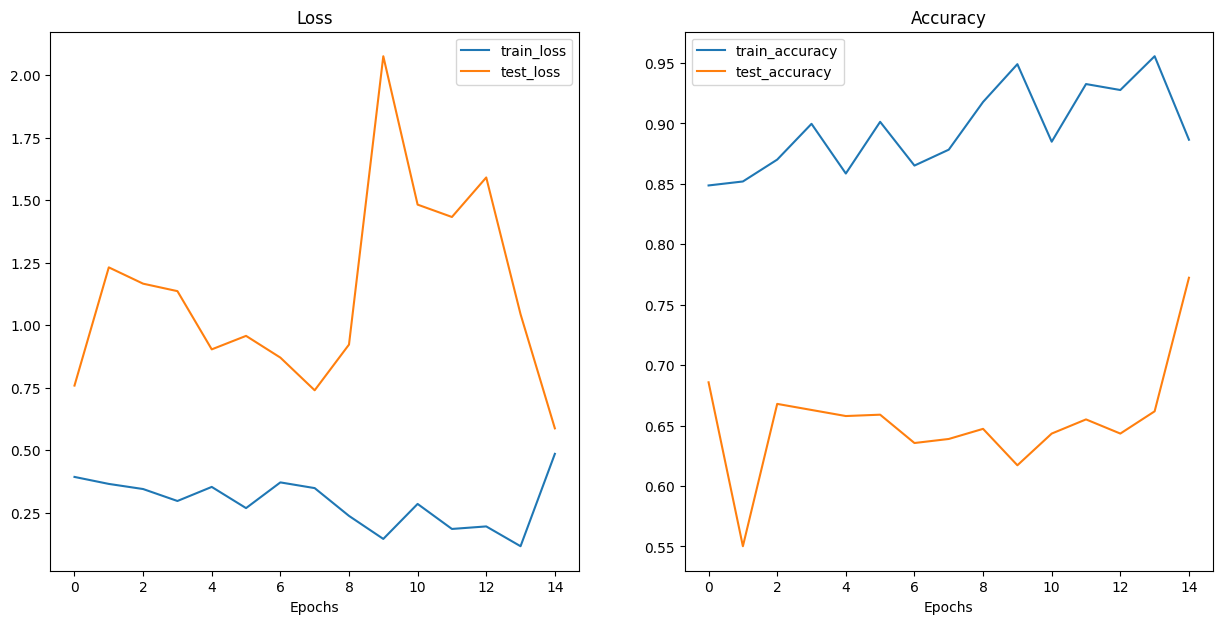

In [26]:
# Get the plot_loss_curves() funtion from helper_functions.py
from driveG.MyDrive.GP1.Graduation_Project_PCOS.going_modular import helper_functions

helper_functions.plot_loss_curves(results)

In [27]:
!pip install torchmetrics -U mlxtend # we need mlxtend to plot the condusion matrix
import torchmetrics, mlxtend
print(f"mlxtend version {mlxtend.__version__}") # must be version 0.19.0 or higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version 0.22.0


In [28]:
from tqdm.auto import tqdm
y_preds = [] # list for storing the model predictions
y_targets = [] # list for storing the true labels of the test data
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions..."): # X and y are the image and label batches in the test dataloader
    # Send data and labels to target device
    X, y = X.to(device), y.to(device)
    # Add the true labels to the y_targets list
    y_targets.append(y.cpu())
    # Do the forward pass on one batch
    y_logit = model_0(X).squeeze()
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.round(torch.sigmoid(y_logit))
    # append to y_preds list & Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu()) # must be on CPU in order to be visualized

y_pred_tensor = torch.cat(y_preds) # concatenating all the prediction tensors into a single prediction tensor
y_target_tensor = torch.cat(y_targets)
y_pred_tensor[:10], y_target_tensor[:10]

Making Predictions...:   0%|          | 0/8 [00:00<?, ?it/s]

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

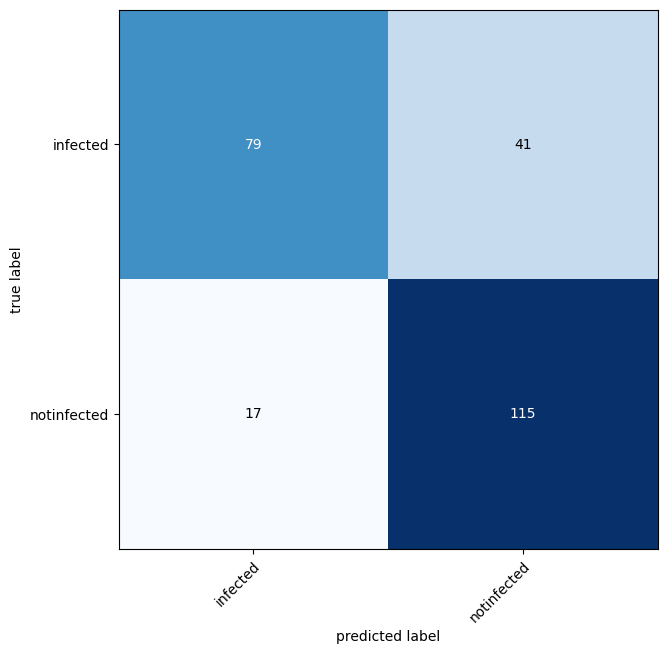

In [29]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="binary", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_target_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names,
    figsize=(10, 7)
)

# Saving the model

In [31]:
FILE = "/content/driveG/MyDrive/GP2/Without_grayscale_tansform_Model_From_Scratch.pth"
torch.save(model_0, FILE)